# Clustering frequency response of pixels

Focus on ABRAÇOS campaigns.


In [1]:
# Indicate file paths and assert file existence
import os
from pathlib import Path

raw_data_path = Path("../data/raw/")
raw_acoustic_A1_path = raw_data_path / "acoustic-data/netCDF-echointegrations/Abracos_A1/high-res/"

leg1_path = raw_acoustic_A1_path / "LEG01/IRD_SOOP-BA_A_20150929T192933Z_ANTEA_FV02_ABRACOS-38-70-120-200_END-20151021T190616Z_C.nc"
leg2_path = raw_acoustic_A1_path / "LEG02/IRD_SOOP-BA_A_20150929T192933Z_ANTEA_FV02_ABRACOS-38-70-120-200_END-20151021T190616Z.nc"

assert os.path.isfile(leg1_path), "LEG1 file not found."
assert os.path.isfile(leg2_path), "LEG2 file not found."

In [2]:
# Import netCDF files as xarray.Dataset's and concatenate them

import xarray as xr

leg1 = xr.open_dataset(leg1_path)
leg2 = xr.open_dataset(leg2_path)

# Add a 'leg' variable to each dataset
leg1 = leg1.assign_coords(leg=(('time',), [1]*leg1.sizes['time']))
leg2 = leg2.assign_coords(leg=(('time',), [2]*leg2.sizes['time']))

# Concatenate and sort by time to ensure order
combined = xr.concat([leg1, leg2], dim='time', data_vars='all')
if 'time' in combined:
    ds = combined.sortby('time')
else:
    ds = combined

print(ds)

<xarray.Dataset> Size: 11GB
Dimensions:                                 (channel: 4, time: 415853,
                                             depth: 745, STRING4_1: 4,
                                             STRING6_2: 6, STRING11_3: 11,
                                             STRING27_4: 27, STRING17_5: 17,
                                             STRING6_6: 6, STRING4_7: 4,
                                             STRING22_8: 22, STRING15_9: 15,
                                             STRING23_10: 23, STRING42_11: 42,
                                             STRING97_12: 97, STRING2_13: 2)
Coordinates:
  * channel                                 (channel) float64 32B 38.0 ... 200.0
  * time                                    (time) datetime64[ns] 3MB 2015-09...
  * depth                                   (depth) float64 6kB 7.5 ... 751.5
    latitude                                (time) float64 3MB -5.514 ... -8.057
    longitude                         

In [3]:
min(ds.depth.values)

np.float64(7.5)

# Distribution of data in the Sv differences space

We want to visualize the data points between 7.5 m and 300 m in a 2D space, where each axis is the difference of Sv between a frequency (70 or 120 kHz) and the reference frequency (38 kHz):
* x-axis: Sv(70kHz) - sv_sub_sub_sub_sub_sub_sub(38kHz)
* y-axis: Sv(120kHz) - Sv(38kHz)

In [56]:
import numpy as np

# Keep only the 3 frequencies of interest (38, 70 and 120 kHz) at depth above 300 m and within the first day
k = 0

ds2 = ds.sel(
    depth=slice(0, 300),
    #time=slice(ds.time.values[0] + np.timedelta64(k, 'D'), ds.time.values[0] + np.timedelta64(k+1, 'D')),
    channel=[38, 70, 120]
)
print(ds2)

<xarray.Dataset> Size: 3GB
Dimensions:                                 (channel: 3, time: 415853,
                                             depth: 293, STRING4_1: 4,
                                             STRING6_2: 6, STRING11_3: 11,
                                             STRING27_4: 27, STRING17_5: 17,
                                             STRING6_6: 6, STRING4_7: 4,
                                             STRING22_8: 22, STRING15_9: 15,
                                             STRING23_10: 23, STRING42_11: 42,
                                             STRING97_12: 97, STRING2_13: 2)
Coordinates:
  * channel                                 (channel) float64 24B 38.0 ... 120.0
  * time                                    (time) datetime64[ns] 3MB 2015-09...
  * depth                                   (depth) float64 2kB 7.5 ... 299.5
    latitude                                (time) float64 3MB -5.514 ... -8.057
    longitude                          

In [57]:
# Compute ΔSv's
dSv_120_38 = ds2.Sv.sel(channel=120) - ds2.Sv.sel(channel=38)
dSv_70_38  = ds2.Sv.sel(channel=70)  - ds2.Sv.sel(channel=38)

# Keep channels, dropping the 'channel' coordinate to avoid merge conflicts
Sv_38 = ds2.Sv.sel(channel=38).drop_vars('channel')
Sv_70 = ds2.Sv.sel(channel=70).drop_vars('channel')
Sv_120 = ds2.Sv.sel(channel=120).drop_vars('channel')

# Compute max Sv over 120, 70 and 38 kHz channels
max_Sv = ds2.Sv.max(dim='channel')

# Combine them into one Dataset
ds_diff = xr.Dataset({
    "dSv_120_38": dSv_120_38,
    "dSv_70_38": dSv_70_38,
    "Sv_38" : Sv_38,
    "Sv_70" : Sv_70,
    "Sv_120": Sv_120,
    "max_Sv_3freq": max_Sv
})

print(ds_diff)

<xarray.Dataset> Size: 3GB
Dimensions:       (time: 415853, depth: 293)
Coordinates:
  * time          (time) datetime64[ns] 3MB 2015-09-29T19:29:42.861096704 ......
  * depth         (depth) float64 2kB 7.5 8.5 9.5 10.5 ... 297.5 298.5 299.5
    latitude      (time) float64 3MB -5.514 -5.514 -5.513 ... -8.057 -8.057
    longitude     (time) float64 3MB -34.84 -34.84 -34.84 ... -34.86 -34.86
    leg           (time) int64 3MB 1 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2 2 2
Data variables:
    dSv_120_38    (time, depth) float32 487MB 0.0 0.0 0.0 16.26 ... nan nan nan
    dSv_70_38     (time, depth) float32 487MB 0.0 0.0 0.0 5.262 ... nan nan nan
    Sv_38         (time, depth) float32 487MB -150.0 -150.0 -150.0 ... nan nan
    Sv_70         (time, depth) float32 487MB -150.0 -150.0 -150.0 ... nan nan
    Sv_120        (time, depth) float32 487MB -150.0 -150.0 -150.0 ... nan nan
    max_Sv_3freq  (time, depth) float32 487MB -150.0 -150.0 -150.0 ... nan nan


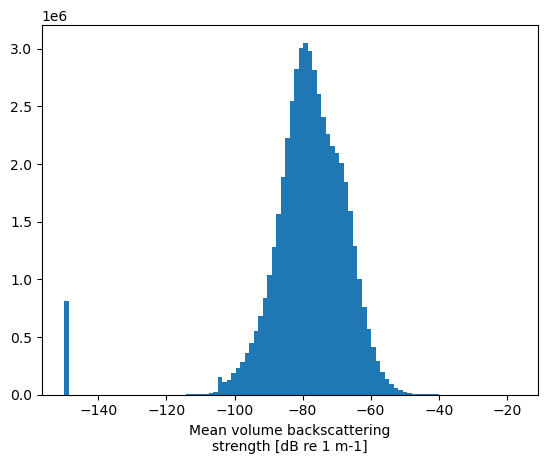

In [72]:
ds_diff.Sv_38.plot.hist(bins=100);

In [59]:
# Remove outliers based on max_Sv_3freq
ds_diff = ds_diff.where(ds_diff.max_Sv_3freq > -120, drop=True)

In [60]:
# Subset
stride_t = 10
stride_d = 2

subset = ds_diff.isel(
    time= slice(0, None, stride_t),
    depth= slice(0, None, stride_d)
)

print(subset)
print(f"N = {subset.depth.size * subset.time.size}")

<xarray.Dataset> Size: 148MB
Dimensions:       (time: 41581, depth: 147)
Coordinates:
  * time          (time) datetime64[ns] 333kB 2015-09-29T19:29:42.861096704 ....
  * depth         (depth) float64 1kB 7.5 9.5 11.5 13.5 ... 295.5 297.5 299.5
    latitude      (time) float64 333kB -5.514 -5.511 -5.509 ... -8.058 -8.057
    longitude     (time) float64 333kB -34.84 -34.84 -34.84 ... -34.86 -34.86
    leg           (time) int64 333kB 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2 2 2
Data variables:
    dSv_120_38    (time, depth) float32 24MB nan nan 20.74 11.36 ... nan nan nan
    dSv_70_38     (time, depth) float32 24MB nan nan 11.1 6.934 ... nan nan nan
    Sv_38         (time, depth) float32 24MB nan nan -95.14 ... nan nan nan
    Sv_70         (time, depth) float32 24MB nan nan -84.04 ... nan nan nan
    Sv_120        (time, depth) float32 24MB nan nan -74.4 ... nan nan nan
    max_Sv_3freq  (time, depth) float32 24MB nan nan -74.4 ... nan nan nan
N = 6112407


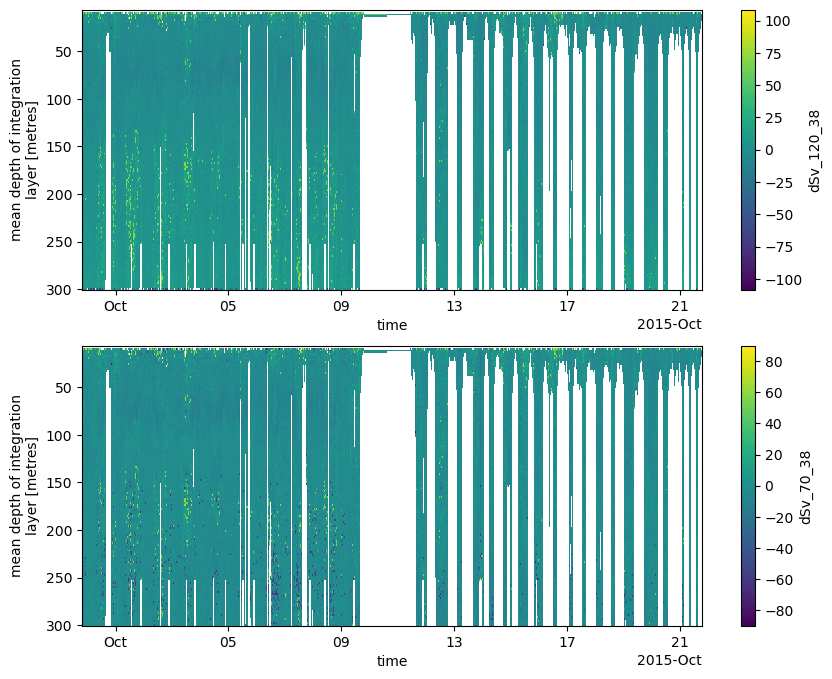

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10, 8))

subset.dSv_120_38.plot(x='time', y='depth', cmap='viridis', ax=ax[0])
subset.dSv_70_38.plot(x='time', y='depth', cmap='viridis', ax=ax[1])

ax[0].invert_yaxis()
ax[1].invert_yaxis()

## Plotting the data points in Sv differences space

### 1. Scatter plot

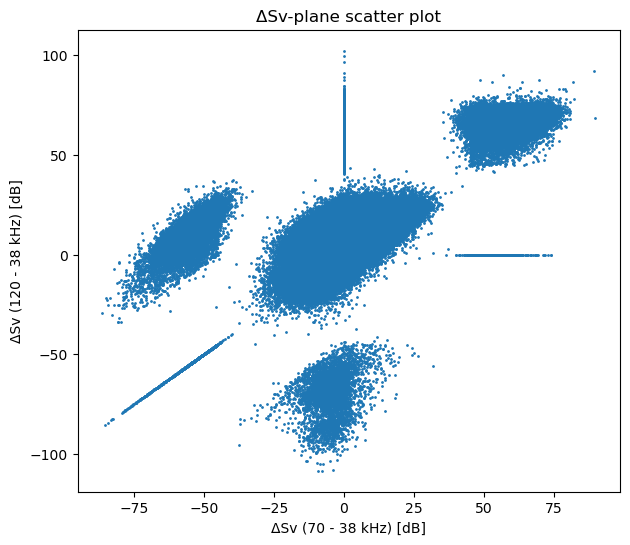

In [61]:
df = subset.to_dataframe().reset_index()

# Drop NaNs if needed
df = df.dropna(subset=["dSv_70_38", "dSv_120_38"])

ax = df.plot.scatter(
    x="dSv_70_38",
    y="dSv_120_38",
    figsize=(7,6),
    s=1
)
ax.set_xlabel("ΔSv (70 - 38 kHz) [dB]")
ax.set_ylabel("ΔSv (120 - 38 kHz) [dB]")
ax.set_title("ΔSv-plane scatter plot");

Hex plot

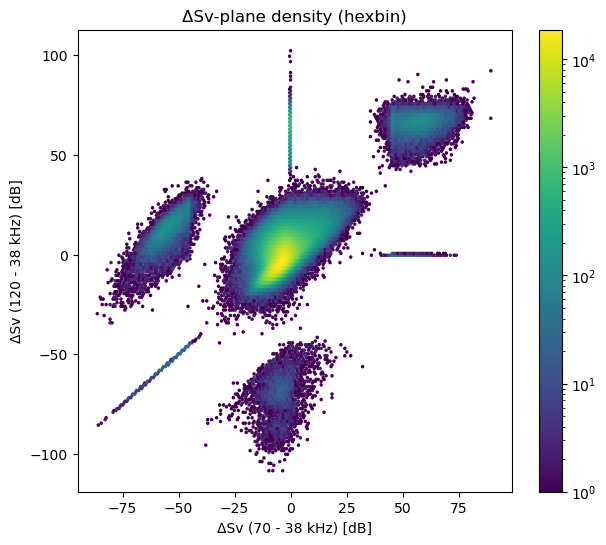

In [62]:
df = subset.to_dataframe().reset_index()

# Drop NaNs if needed
df = df.dropna(subset=["dSv_70_38", "dSv_120_38"])

ax = df.plot.hexbin(
    x="dSv_70_38",
    y="dSv_120_38",
    gridsize=200,     # number of hexagons across x-axis
    cmap="viridis",
    figsize=(7,6),
    bins='log'
)

ax.set_xlabel("ΔSv (70 - 38 kHz) [dB]")
ax.set_ylabel("ΔSv (120 - 38 kHz) [dB]")
ax.set_title("ΔSv-plane density (hexbin)");

In [71]:
x = df[df["dSv_120_38"] == df["dSv_70_38"]]
x[x["dSv_70_38"] < -50]

,time,depth,dSv_120_38,dSv_70_38,Sv_38,Sv_70,Sv_120,max_Sv_3freq,latitude,longitude,leg
26018,2015-09-29 23:16:04.992495872,299.5,-53.408211,-53.408211,-96.591789,-150.0,-150.0,-96.591789,-5.200242,-34.398327,1
41455,2015-09-30 01:33:46.632596992,9.5,-52.524391,-52.524391,-97.475609,-150.0,-150.0,-97.475609,-5.014588,-34.134330,1
100697,2015-09-30 11:46:43.550799616,11.5,-54.623444,-54.623444,-95.376556,-150.0,-150.0,-95.376556,-4.163642,-32.926420,1
103489,2015-09-30 12:11:37.613295104,9.5,-52.974968,-52.974968,-97.025032,-150.0,-150.0,-97.025032,-4.129767,-32.878304,1
106429,2015-09-30 12:38:05.809196800,9.5,-69.339134,-69.339134,-80.660866,-150.0,-150.0,-80.660866,-4.094143,-32.827712,1
...,...,...,...,...,...,...,...,...,...,...,...
5973217,2015-10-21 13:15:47.900296704,45.5,-56.285271,-56.285271,-93.714729,-150.0,-150.0,-93.714729,-8.386999,-34.738816,2
6092566,2015-10-21 18:31:55.949495040,15.5,-62.592804,-62.592804,-87.407196,-150.0,-150.0,-87.407196,-8.131610,-34.843145,2
6098446,2015-10-21 18:42:09.480697600,15.5,-60.020737,-60.020737,-89.979263,-150.0,-150.0,-89.979263,-8.107712,-34.839389,2
6104325,2015-10-21 18:52:23.746396160,13.5,-54.922157,-54.922157,-95.077843,-150.0,-150.0,-95.077843,-8.084838,-34.845831,2


# Simple clustering with KMeans